In [2]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/cv.allset_train.iforest.yaml/evalreports/'))
assert os.path.isdir(maindir)


# create evaluations all:
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)

print('Creating evaluations all (html)')
sod_core_eval.aggeval(maindir, format='html')

print('Creating evaluations all (hdf)')
sod_core_eval.aggeval(maindir, format='hdf')

path = os.path.join(maindir, 'evaluations.all.hdf')


dfr = pd.read_hdf(path)
print('evaulation dataframe.\n\nColumns:\n' + str(dfr.columns.tolist()))
print('\nclassname distinct values:\n' + str(np.unique(dfr['classname'])))

Creating evaluations all (html)
Creating evaluations all (hdf)
evaulation dataframe.

Columns:
['% rec.', 'Mean log_loss', 'behaviour', 'classname', 'clf', 'contamination', 'features', 'max_samples', 'n_estimators']

classname distinct values:
['ok' 'outl. (wrong inv)' 'unlabeled (Me suspicious outl.)'
 'unlabeled (Me unknown)']


In [3]:
# Some tries to embed the html page, NOT WORKING

# from IPython.display import IFrame
# IFrame(src='file://' + os.path.join(maindir, 'evaluations.all.html'), width=700, height=600)

# from IPython.display import Javascript
# %%javascript
# from IPython.core.display import display, HTML
# display(HTML(open(os.path.join(maindir, 'evaluations.all.html')).read()))


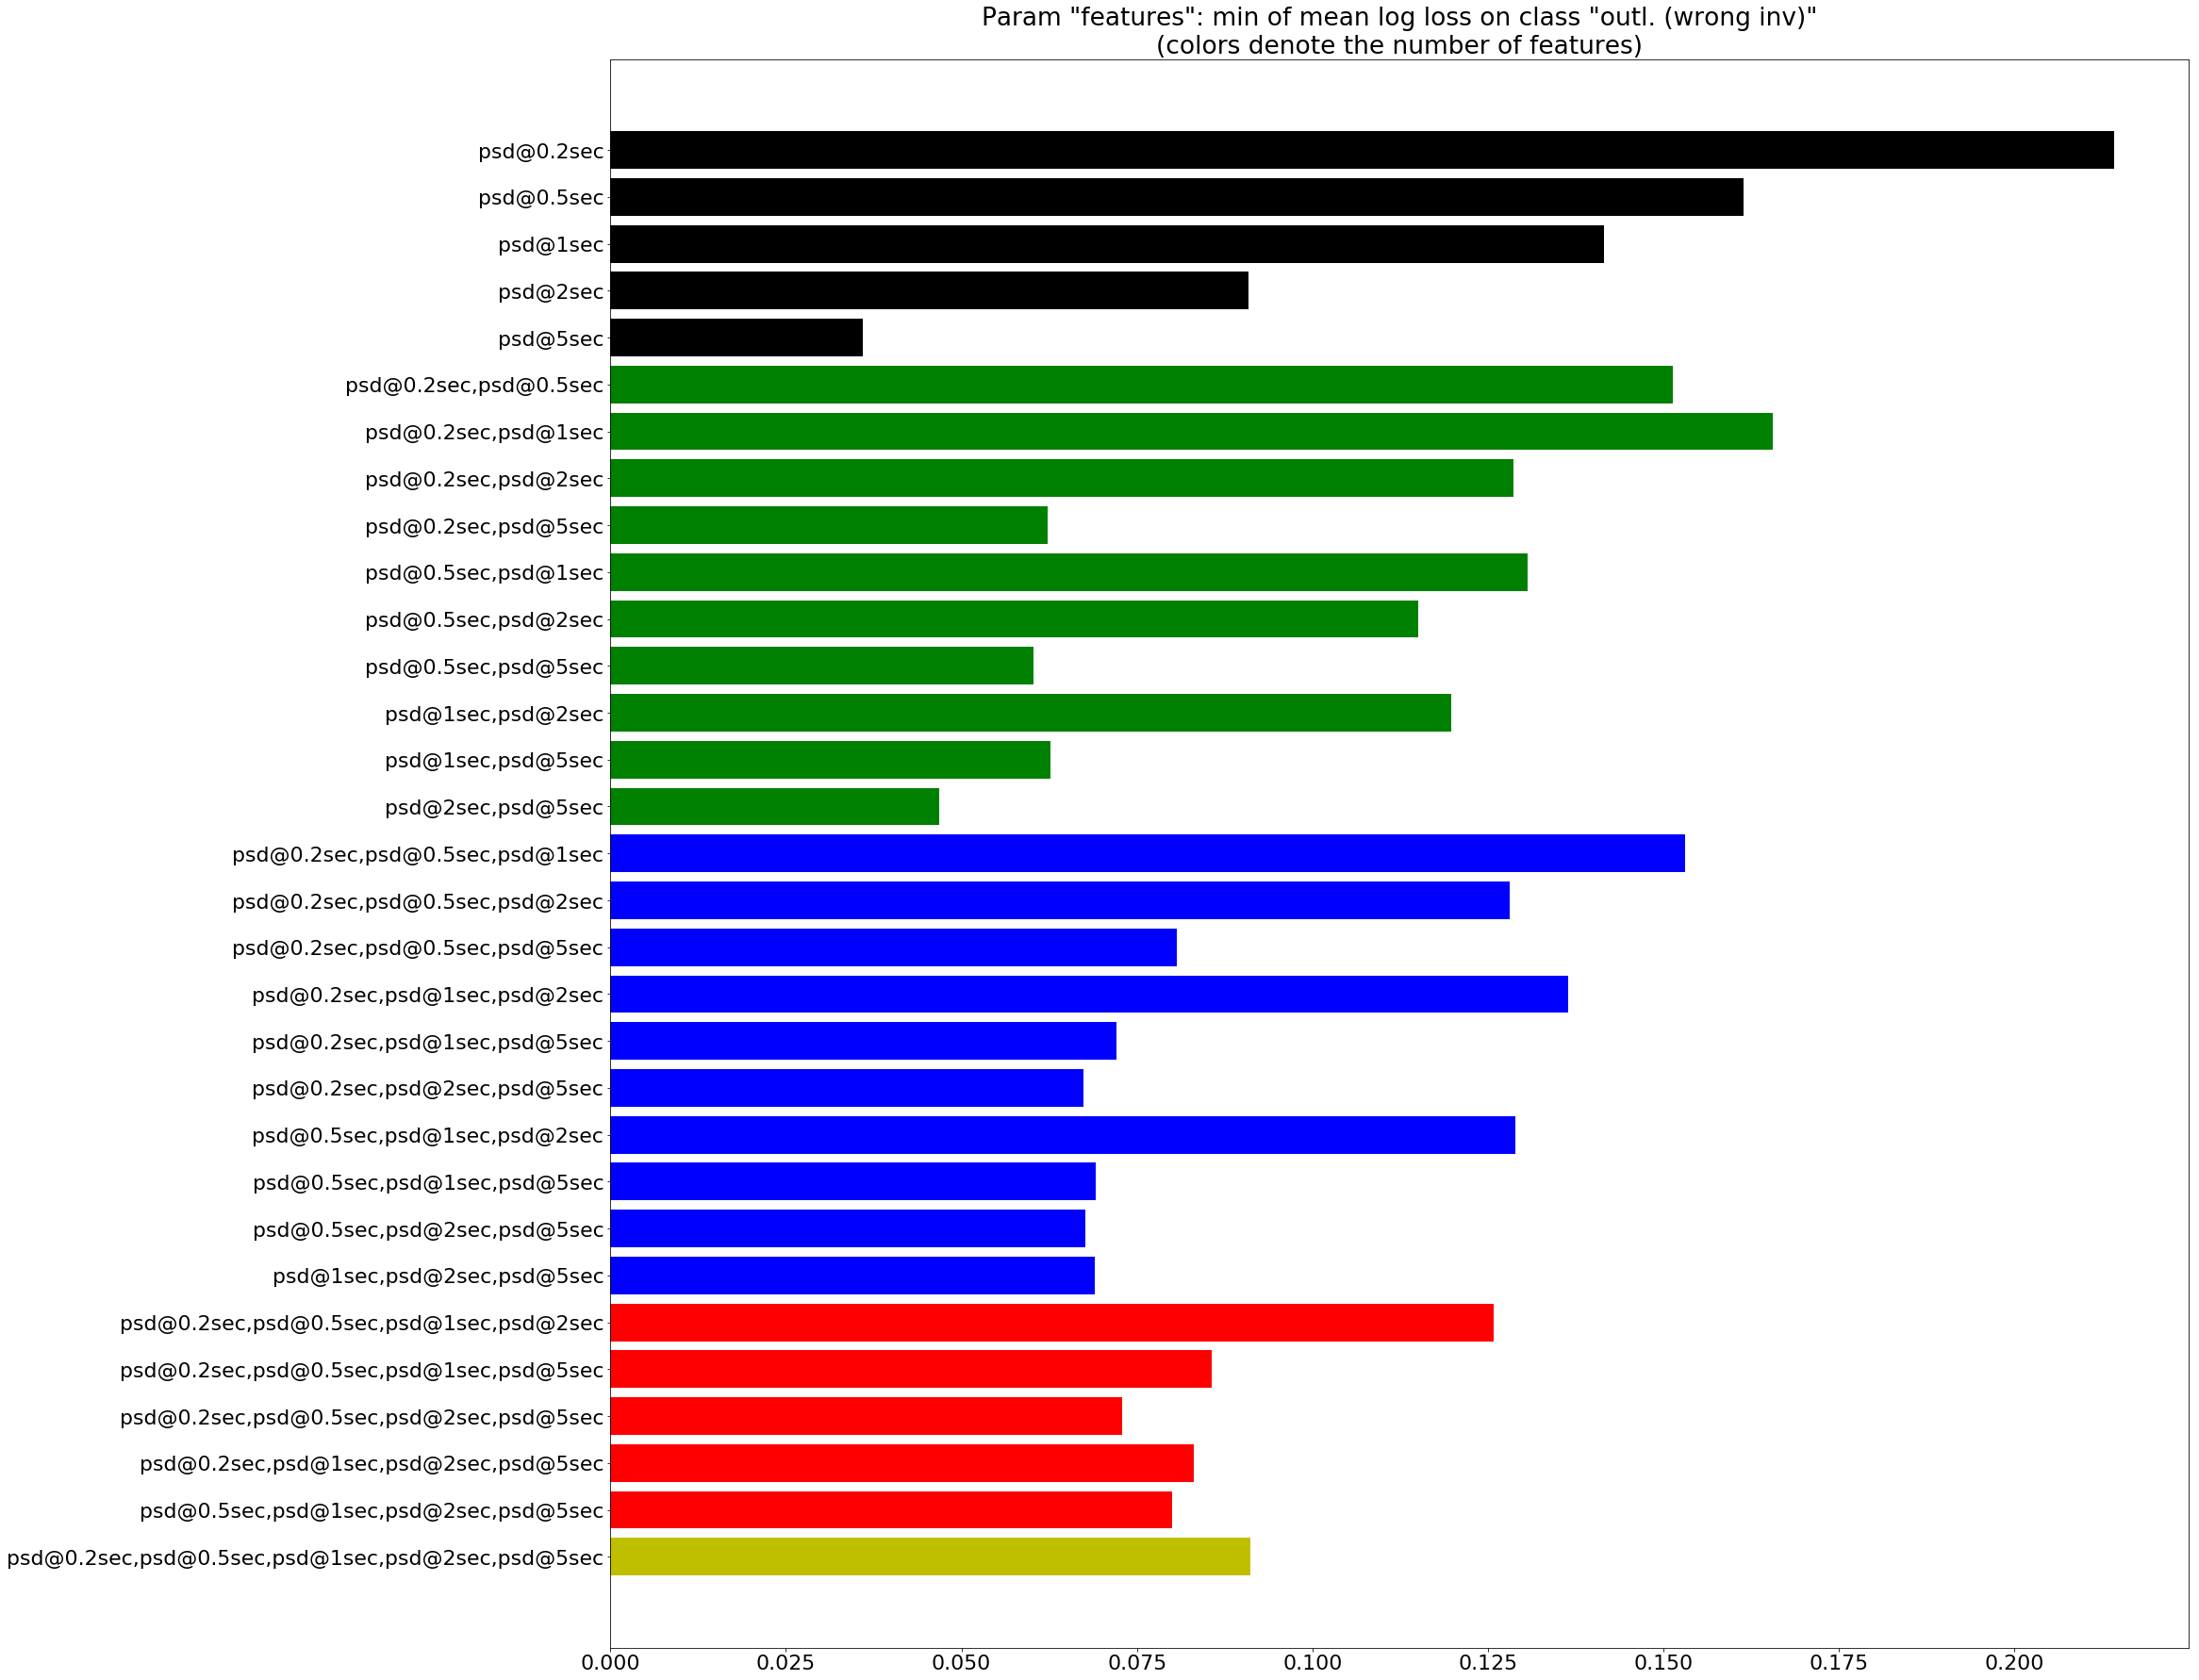

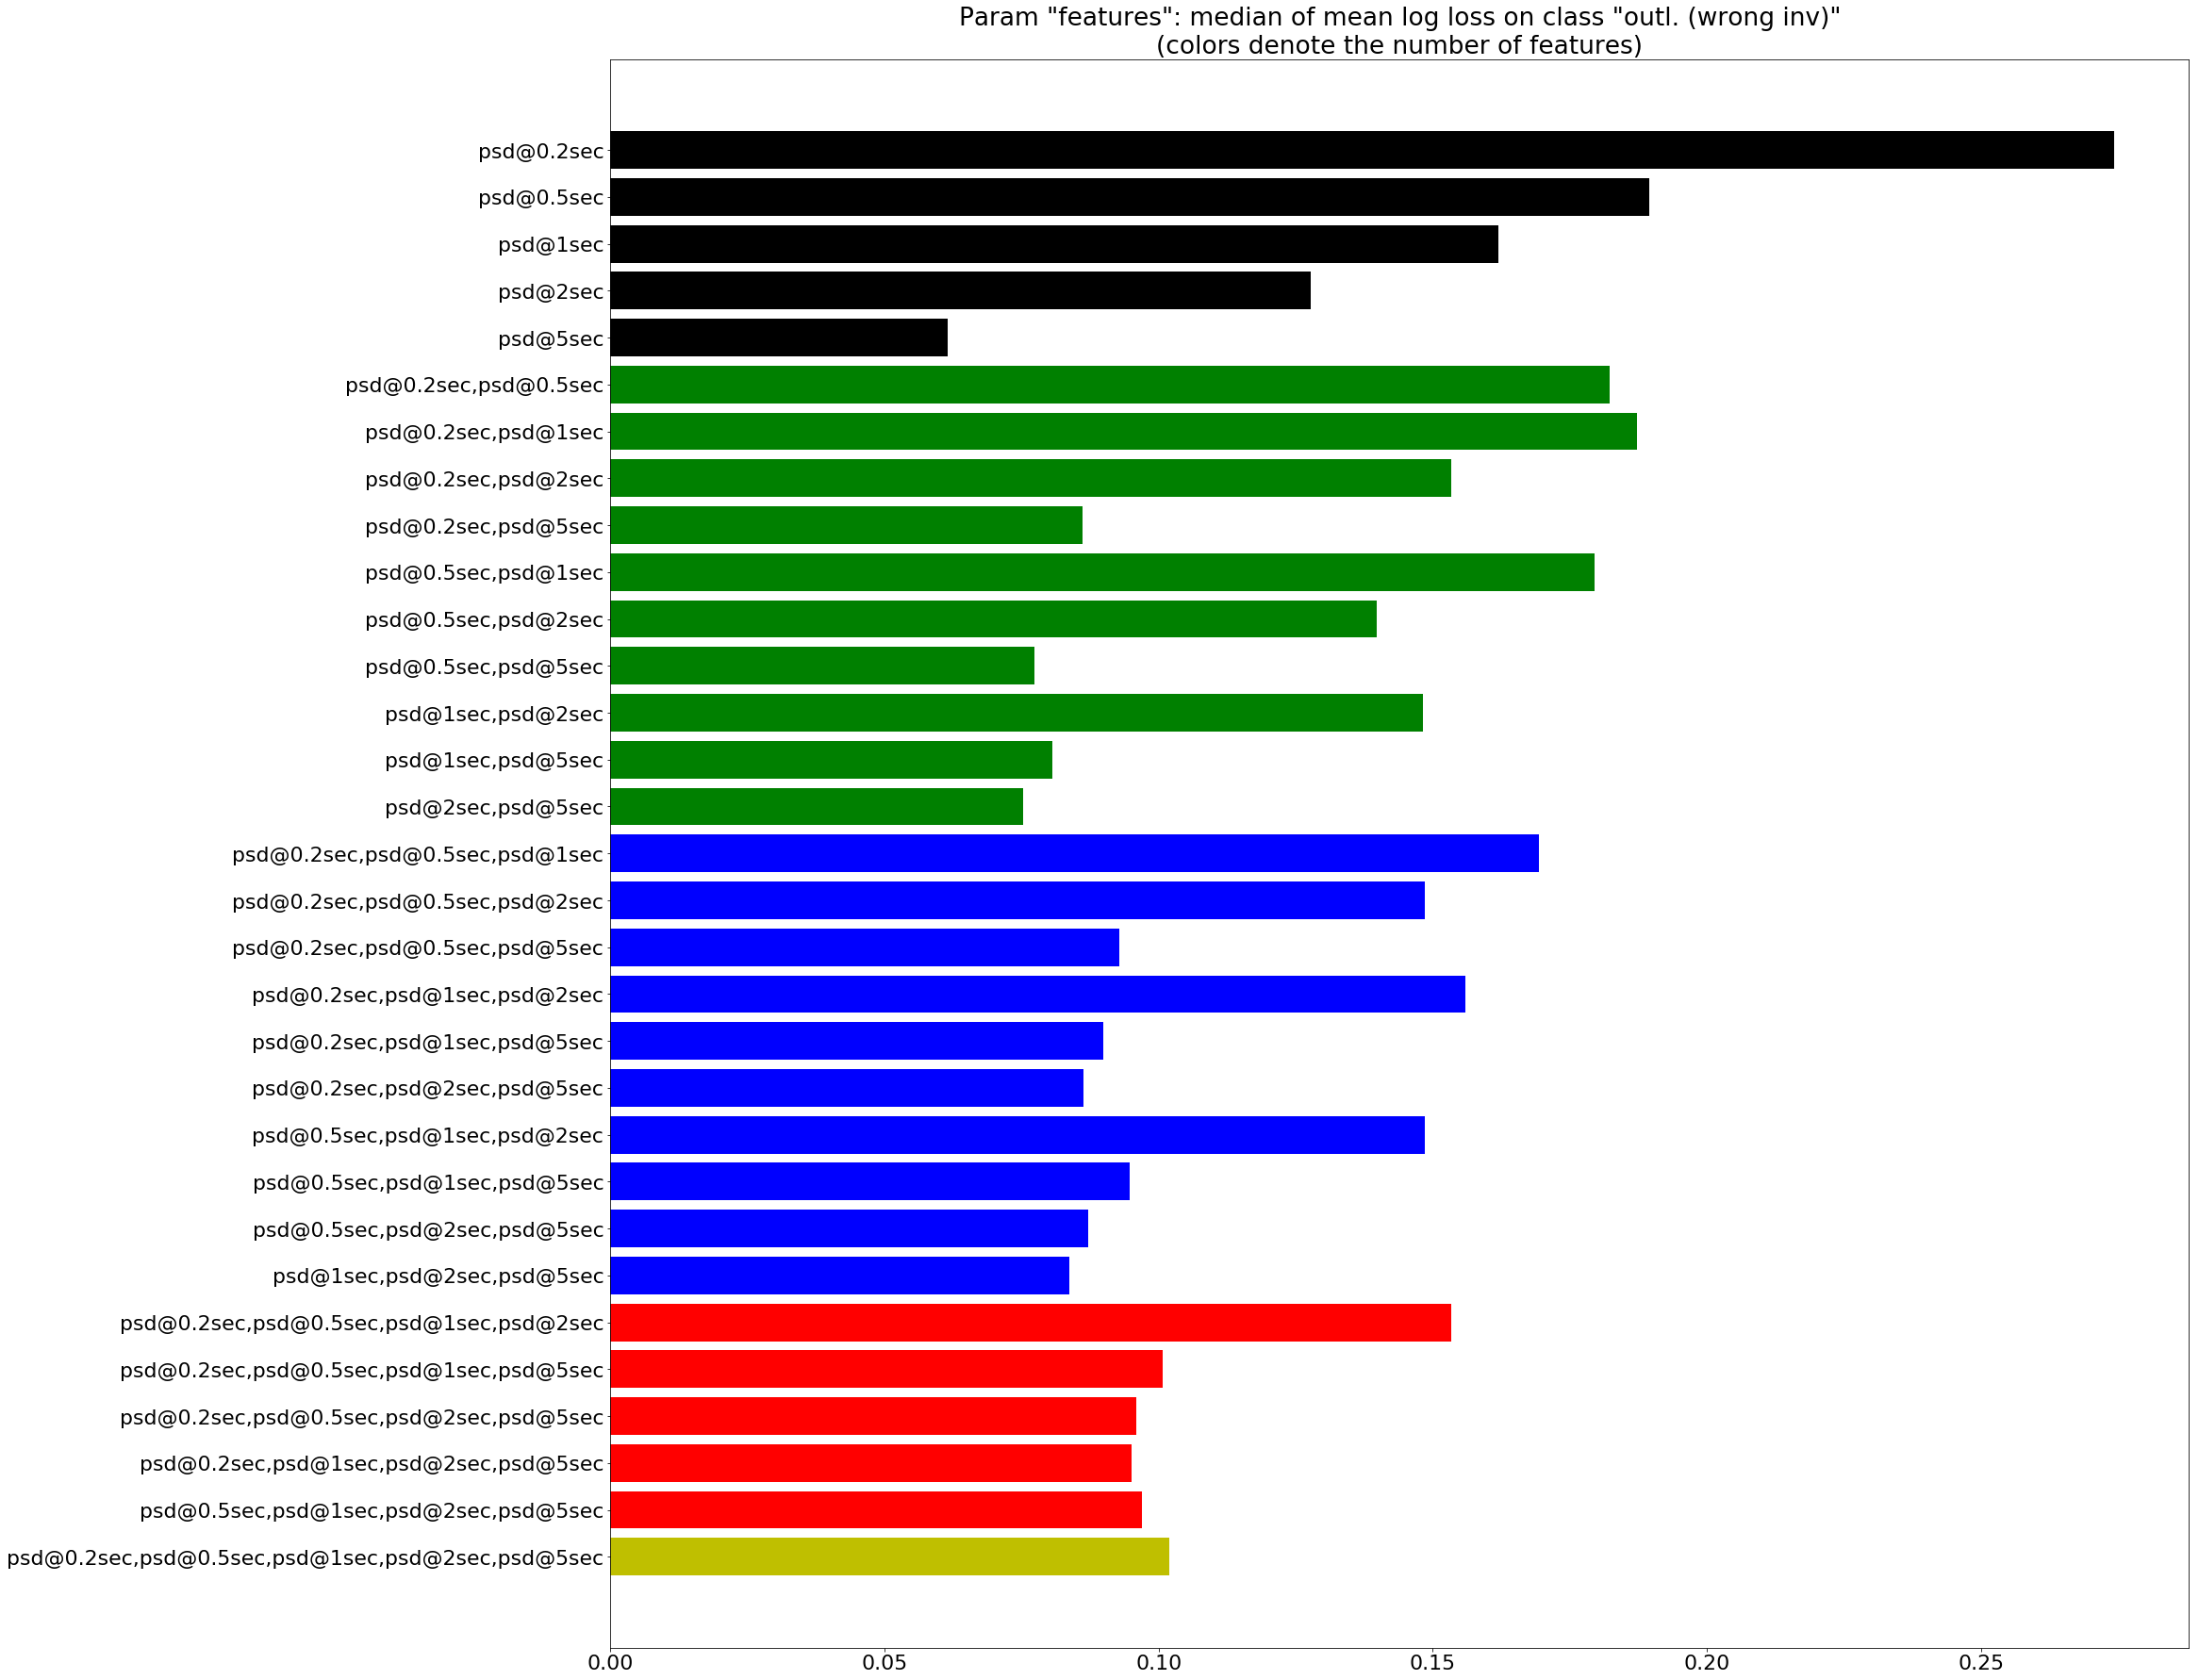

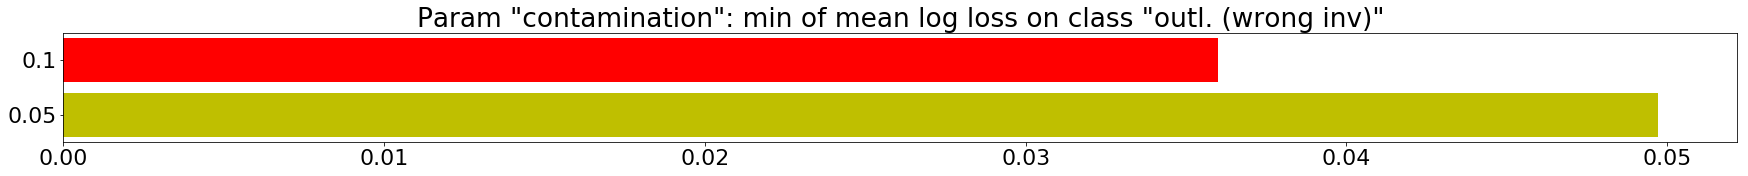

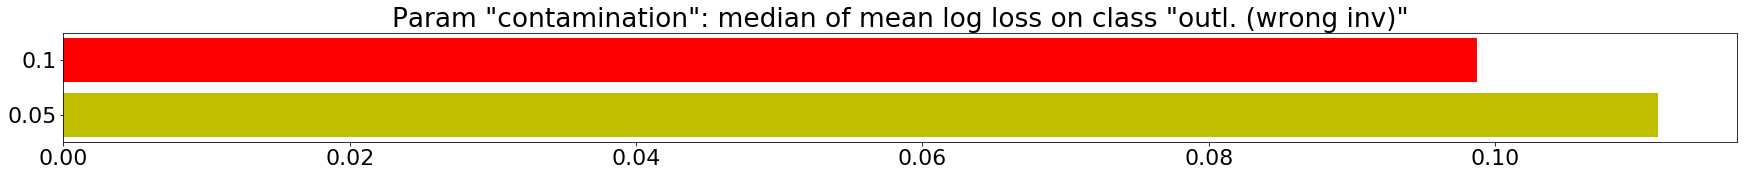

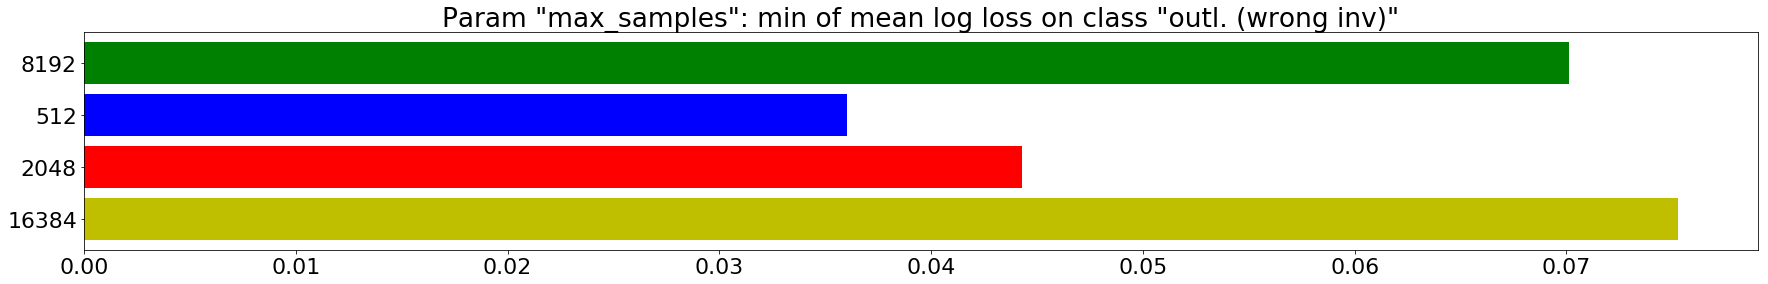

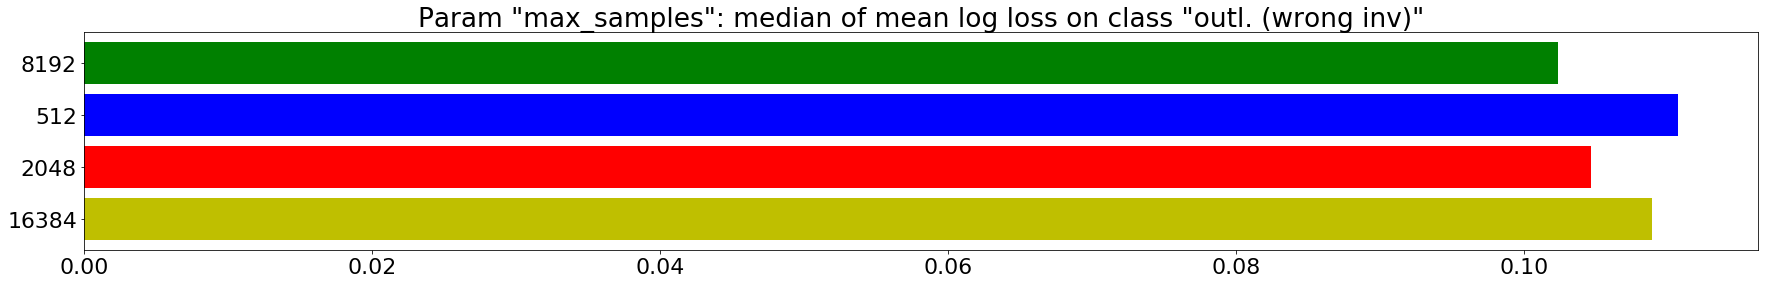

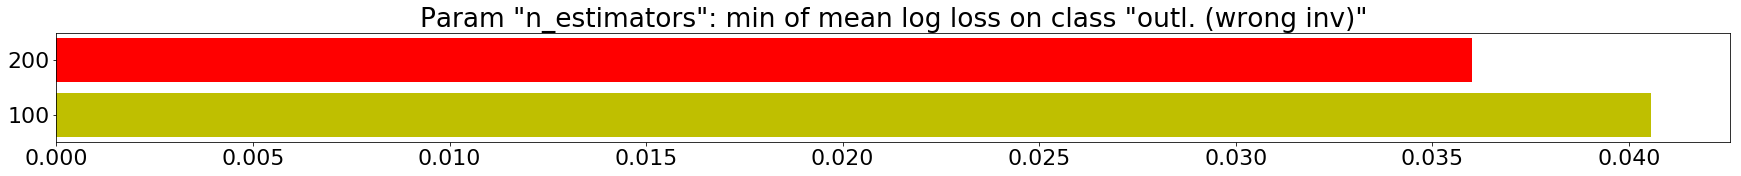

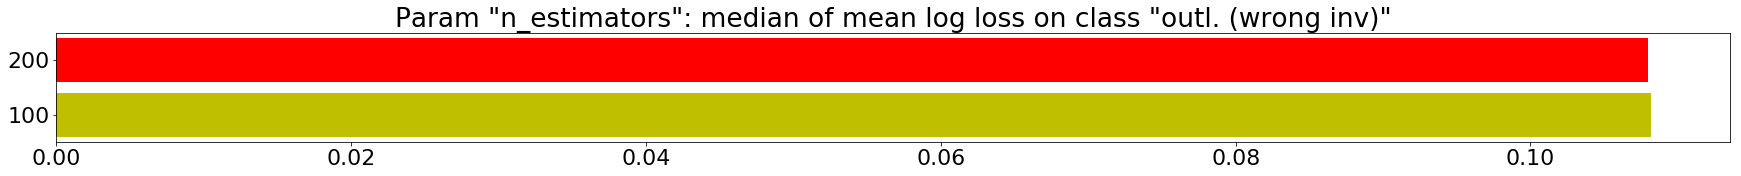

In [4]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# tmp_fig_size = matplotlib.rcParams['figure.figsize']
# matplotlib.rcParams['figure.figsize']
# plt.rcParams.update({'font.size': 30})
# plt.rcParams.update({'figure.figsize': (22, 22)})


class_ = 'outl. (wrong inv)'

from itertools import cycle
basecolors = ['y', 'r', 'b', 'g', 'k']

columns = ['features', 'contamination', 'max_samples', 'n_estimators']



for col in columns:
        
    colors_ = iter(cycle(basecolors))
    colorsdict = defaultdict(lambda: next(colors_))

    # printing per feature with hbars (https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barh.html)
    numfeat2color = {1:'y', 2: 'r', 3: 'b', 4: 'g', 5: 'k'}

    data = defaultdict(list)
    for _, df_ in dfr.groupby(col):
        data[_].extend(_ for _ in df_[df_.classname == class_]['Mean log_loss'])

    if col == 'features':
        labels = sorted(data.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
        colors = [colorsdict[len(_.split(','))] for _ in labels]
        labelcap = '\n(colors denote the number of features)'
    else:
        labels = sorted((_ for _ in data), key=str)
        colors = [colorsdict[_] for _ in labels]
        labelcap = ''

    size = len(data)
    with plotparams({'figure.figsize': (30, size), 'font.size': 22}):

        avg = {_: np.nanmin(data[_]) for _ in data}
        # labels = sorted(avg.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
        # colors = [numfeat2color[len(_.split(','))] for _ in labels]
        # colors = [next(colors) for _ in labels]
        ypos = np.arange(len(labels))
        plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
        plt.title('Param "%s": min of mean log loss on class "%s"%s' % (col, class_, labelcap))
        plt.gca().set_yticks(ypos)
        # plt.gca().set_yticklabels((_.replace(",", ", ") for _ in labels))
        plt.gca().set_yticklabels(labels)

        # plt.xlabel('number of features')
        # plt.xticks(rotation=90)
        plt.show()

        avg = {_: np.quantile(data[_], 0.5) for _ in data}
        # labels = sorted(avg.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
        ypos = np.arange(len(labels))
        plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
        plt.title('Param "%s": median of mean log loss on class "%s"%s' % (col, class_, labelcap))
        plt.gca().set_yticks(ypos)
        # plt.gca().set_yticklabels((_.replace(",", ", ") for _ in labels))
        plt.gca().set_yticklabels(labels)

        # labels = sorted(avg.keys())
        # ypos = np.arange(len(labels))
        # plt.bar(avg.keys(), avg.values())
        # plt.title('Median of mean log loss on class "%s" ' % class_)
        # plt.xlabel('number of features')
        # plt.xticks(rotation=90)
        plt.show()
        
        print()

    # print(pd.Series(avg))

In [5]:
root = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations', 'results', 'cv.allset_train.iforest.yaml'))
assert(os.path.isdir(root))

# adding the two best with two features, with contamination 5% an 10%
fnames = {
    'psd[2,5] 0.1 512': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.1&max_samples=512&n_estimators=100&behaviour=new',
    'psd[2,5] 0.05 2048': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new',
    #'cont10%, samples2048': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.1&max_samples=2048&n_estimators=200&behaviour=new',
    #'cont5%, samples512': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.05&max_samples=512&n_estimators=200&behaviour=new',
}


clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))

print('loading source trainset')
dataframe = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)

psd[2,5] 0.1 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[2,5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
loading source trainset



psd[2,5] 0.1 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


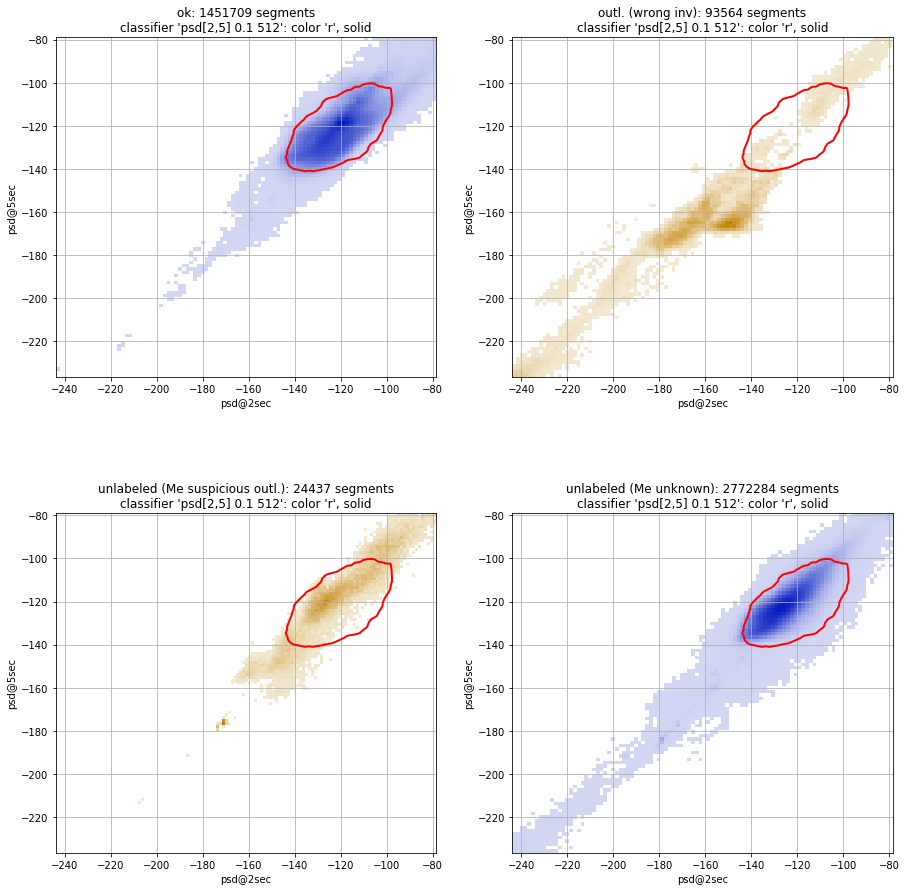


psd[2,5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


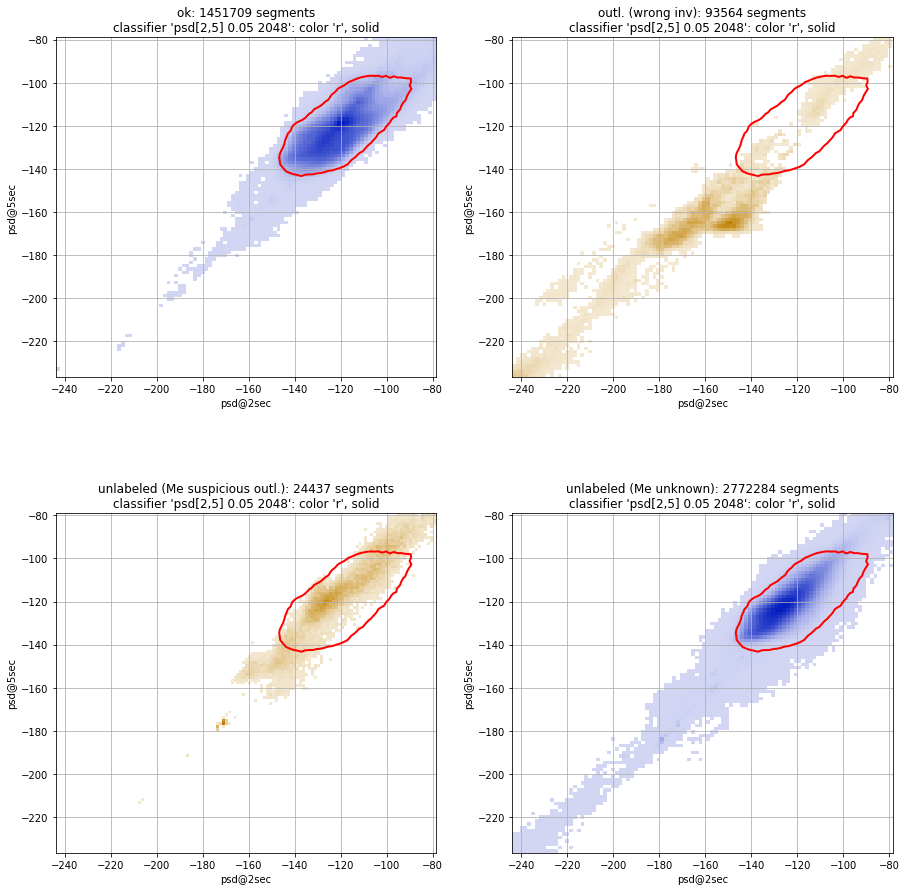

In [6]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

feats = ['psd@2sec', 'psd@5sec']
%matplotlib inline
with plotparams({'figure.figsize': (15, 15)}):
    for clf_key, clf_val in clfs.items():
        print('\n%s: %s' % (str(clf_key), str(clf_val)))
        sod_plot.plot(dataframe, *feats, axis_lim=.9901, clfs={clf_key: clf_val})
        plt.show()

In [15]:
# adding now the two best overall:

fnames['psd[5] 0.1 512'] = 'IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=100&behaviour=new'
fnames['psd[5] 0.05 2048'] = 'IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new'

clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}
for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))

print('Opening predictions hdf files\n')
preds = {k: pd.read_hdf(os.path.join(root, 'predictions', v + '.hdf')) for k, v in fnames.items()}

print('\nSetting categorical data and score samples')
for name, pred_df in preds.items():
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    pred_df['score_samples'] = -(pred_df['decision_function'] + clfs[name].offset_)
    preds[name] = pred_df

print('\nDone. Predictions dataframes columns:')
print(list(preds.values())[0].columns.tolist())  # one is sufficient
print()

psd[2,5] 0.1 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[2,5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[5] 0.05 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[5] 0.1 512: IsolationForest(behaviour='new', bootstrap=Fal


CONFUSION MATRICES AT SEGMENT LEVEL


psd[2,5] 0.1 512 | conf. matrx
                                   total  correctly predicted  mean log loss
outl. (wrong inv)                  70136                68896       0.117165
unlabeled (Me suspicious outl.)    18108                 6636       0.305419
unlabeled (Me unknown)           1957799              1783704       0.257472

psd[2,5] 0.05 2048 | conf. matrx
                                   total  correctly predicted  mean log loss
outl. (wrong inv)                  70136                68736       0.119892
unlabeled (Me suspicious outl.)    18108                 6145       0.315209
unlabeled (Me unknown)           1957799              1816807       0.251497

psd[5] 0.05 512 | conf. matrx
                                   total  correctly predicted  mean log loss
outl. (wrong inv)                  70130                69137       0.106484
unlabeled (Me suspicious outl.)    18108                 7349       0.286265
unlabeled (Me unkn

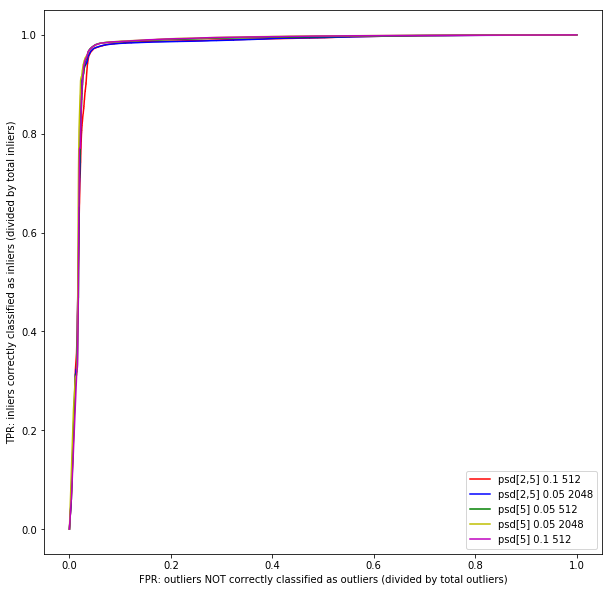

In [16]:
from sklearn.metrics import roc_curve

from itertools import cycle
import numpy as np




def select(df, classes):
    sel = None
    for k, v in classes.items():
        if sel is None:
            sel = v(df)
        else:
            sel |= v(df)
    return df[sel]

# select all classes except inliers (used for training):
classnames = sod_core_dataset.allset_train.classnames[1:]
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}


# from sklearn.metrics.log_loss
print('\nCONFUSION MATRICES AT SEGMENT LEVEL\n')
for name, prd_df in preds.items():

    k = 'score_samples'
    print('\n%s | conf. matrx' % str(name))
    data = []
    for cname, class_selector in classes.items():
        _prd_df = prd_df[class_selector(prd_df)]
        expected_class = _prd_df['outlier'].astype(float)
        if (expected_class == 1).all():
            correctly_predicted = _prd_df['score_samples'] >= 0.5
        elif (expected_class == 0).all():
            correctly_predicted = _prd_df['score_samples'] < 0.5
        else:
            raise ValueError('mixing expected classes for class %s' % cname)
        assert not np.isnan(expected_class).any()
        assert not np.isnan(correctly_predicted).any()
        assert not np.isnan(_prd_df['score_samples']).any()
        log_loss = -np.log10(np.clip(1 - np.abs(expected_class - _prd_df['score_samples']), 1e-15, 1-1e-15))
        # when expected == predicted => log_loss = 1
        # when expected=1 and predicted=0 (or viceversa) => log_loss = 0
        
        # log_loss = np.log10(log_loss)
        # print(log_loss)
        data.append([len(_prd_df), correctly_predicted.sum(), log_loss.mean()])
    print(pd.DataFrame(data, columns=['total', 'correctly predicted', 'mean log loss'], index=list(classes.keys())))



# roc curve classes ignore the Me suspicious outliers (use only more "sure" classes):
rc_classnames = sod_core_dataset.allset_train.classnames[1], sod_core_dataset.allset_train.classnames[-1] 
rc_classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in rc_classnames}

#print('Scores of classes: %s' % (str(list(classes.keys()))))

colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in preds.items():
        
        k = 'score_samples'
#        print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = select(prd_df, rc_classes)
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['score_samples'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name)
        # print([thresholds[np.argwhere(tpr>=0.9)[-1][0]], thresholds[np.argwhere(fpr<=0.1)[-1][0]]])

    print('\nROC curves (only using classes: %s)' % str(rc_classnames))

    plt.ylabel('TPR: inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('FPR: outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
    plt.show()

In [17]:
from sod.core import pdconcat

spreds = {}  # station predictions dataframes

groupcols = ['cha_id', 'dataset_id', 'station_id', 'location_code']
added_cols = ['subclass', 'outlier', 'score_samples', 'decision_function', 'num segs']

print('Creating stations prediction dataframes')
print(groupcols)

for name, prd_df in preds.items():
    prd_df = select(prd_df, classes)
    data = []
    for colz_vals, df in prd_df.groupby(groupcols):
        if df.empty:
            continue
        row = list(colz_vals)
        zum = df['outlier'].sum()
        assert zum == 0 or zum == len(df)
        assert len(pd.unique(df['subclass'])) == 1
        row += [df.iloc[0]['subclass'], df.iloc[0]['outlier'],
                df.score_samples.median(), df.decision_function.median(), len(df)]
        data.append(row)
    spreds[name] = pd.DataFrame(data, columns = groupcols + added_cols)
    # spreds[name] = pdconcat(data)
print('Done')

Creating stations prediction dataframes
['cha_id', 'dataset_id', 'station_id', 'location_code']
Done



CONFUSION MATRICES AT STATION LEVEL


psd[2,5] 0.1 512 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.110202
unlabeled (Me suspicious outl.)     17                    7       0.308632
unlabeled (Me unknown)            2330                 2216       0.252363

psd[2,5] 0.05 2048 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.115404
unlabeled (Me suspicious outl.)     17                    6       0.318409
unlabeled (Me unknown)            2330                 2226       0.246677

psd[5] 0.05 512 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.102809
unlabeled (Me suspicious outl.)     17                    7       0.285931
unlabeled (Me unknown)            2330  

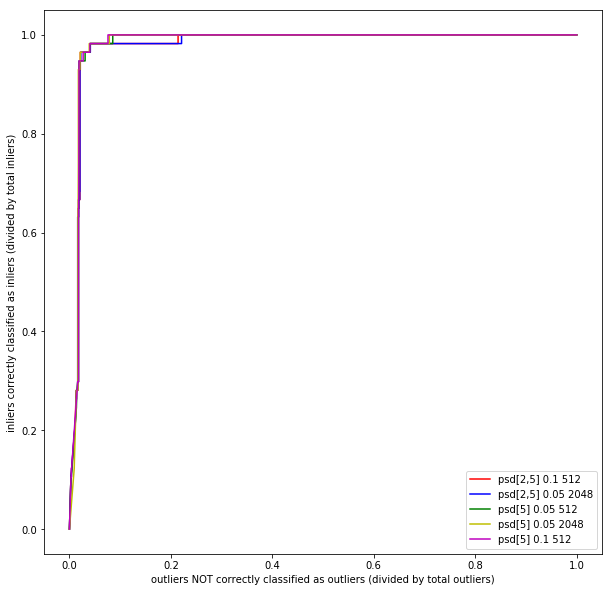

In [18]:
# from sklearn.metrics.log_loss
print('\nCONFUSION MATRICES AT STATION LEVEL\n')
for name, prd_df in spreds.items():

    k = 'score_samples'
    print('\n%s | conf. matrx' % str(name))
    data = []
    for cname, class_selector in classes.items():
        _prd_df = prd_df[class_selector(prd_df)]
        expected_class = _prd_df['outlier'].astype(float)
        if (expected_class == 1).all():
            correctly_predicted = _prd_df['score_samples'] >= 0.5
        elif (expected_class == 0).all():
            correctly_predicted = _prd_df['score_samples'] < 0.5
        else:
            raise ValueError('mixing expected classes for class %s' % cname)
        assert not np.isnan(expected_class).any()
        assert not np.isnan(correctly_predicted).any()
        assert not np.isnan(_prd_df['score_samples']).any()
        log_loss = -np.log10(np.clip(1 - np.abs(expected_class - _prd_df['score_samples']), 1e-15, 1-1e-15))
        # when expected == predicted => log_loss = 1
        # when expected=1 and predicted=0 (or viceversa) => log_loss = 0
        
        # log_loss = np.log10(log_loss)
        # print(log_loss)
        data.append([len(_prd_df), correctly_predicted.sum(), log_loss.mean()])
    print(pd.DataFrame(data, columns=['total', 'correctly predicted', 'mean log loss'], index=list(classes.keys())))




colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in spreds.items():
        
        k = 'score_samples'
#         print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = select(prd_df, rc_classes)
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['score_samples'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name)
        # mxx = np.argmax(fpr*(1.0-tpr))
        # print('%s' % str([fpr[mxx], tpr[mxx]]))
        #plt.scatter(fpr[mxx], tpr[mxx], color=_[0])

    print('\nROC curves (only using classes: %s)' % str(rc_classnames))

    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
    plt.show()

In [19]:
colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
from collections import defaultdict
# unique station keys mapped to the classifier names for which the station is misclassified:
# many_wrong = defaultdict(list)
# for name, prd_df in spreds.items():   
#     prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#     for data in zip(*[prd_df_msclf[_] for _ in groupcols]):
#         many_wrong[data].append(name)
#         print(data)
#         raise
#     print('\n\n%s: %d misclassified (0 ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#     print(prd_df_msclf.to_string(index=False))

for name, prd_df in spreds.items():   
    prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
    print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
    prd_df_msclf.drop(['decision_function'], 1, inplace=True)
    print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))



psd[2,5] 0.1 512: 125 misclassified (score_samples: 0=ok, 1=anomaly)

cha_id  dataset_id  station_id location_code                 subclass  outlier  score_samples  num segs
   BH           2        3258                                            True       0.433563       712
   BH           2        3246                unlabeled.maybe.outlier     True       0.408503      1071
   BH           2         434                unlabeled.maybe.outlier     True       0.409318       665
   BH           2        3242                unlabeled.maybe.outlier     True       0.409742       601
   BH           2        1126                unlabeled.maybe.outlier     True       0.410985      2463
   BH           2        3225                unlabeled.maybe.outlier     True       0.411132       855
   BH           2        2893                unlabeled.maybe.outlier     True       0.422111       507
   BH           2        1210                unlabeled.maybe.outlier     True       0.425650      2607


JUST A TRY WITH FAKE DATA


ROC curves classifier with better REC RATE, worst scores


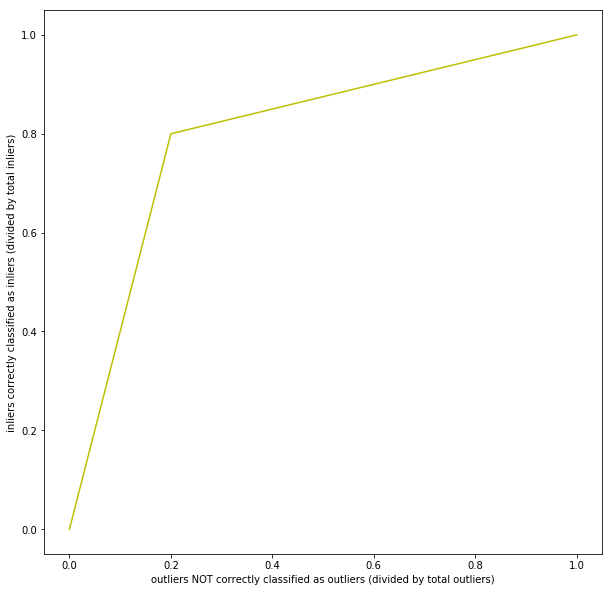


ROC curves classifier with worse REC RATE, better scores


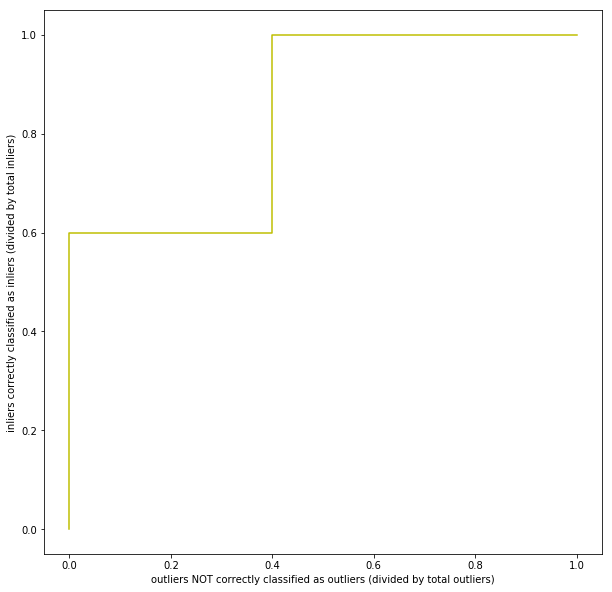

In [12]:
# let's make a try:
y_true = [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
y_pred = [0] * 4 + [1, 0] + [1]*4

print('JUST A TRY WITH FAKE DATA\n')
with plotparams({'figure.figsize': (10, 10)}):

    print('\nROC curves classifier with better REC RATE, worst scores')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color=_[0])
    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.show()

y_true = [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
y_pred = [0] * 3 + [0.6, 0.6, 0.4, 0.4] + [1] * 3

with plotparams({'figure.figsize': (10, 10)}):

    print('\nROC curves classifier with worse REC RATE, better scores')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color=_[0])
    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.show()

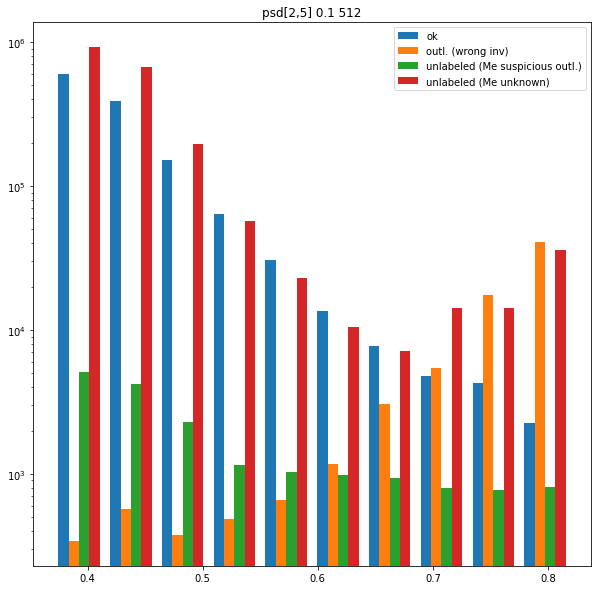

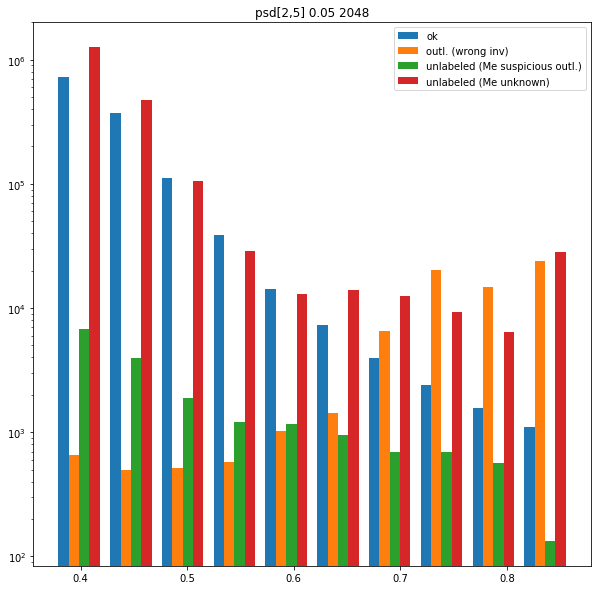

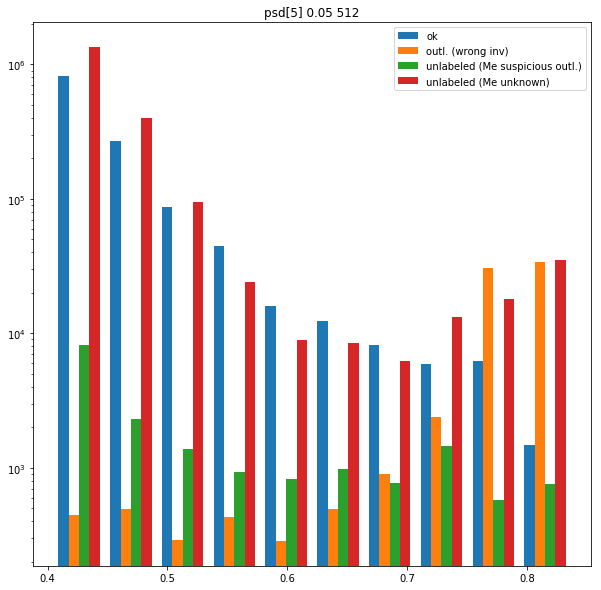

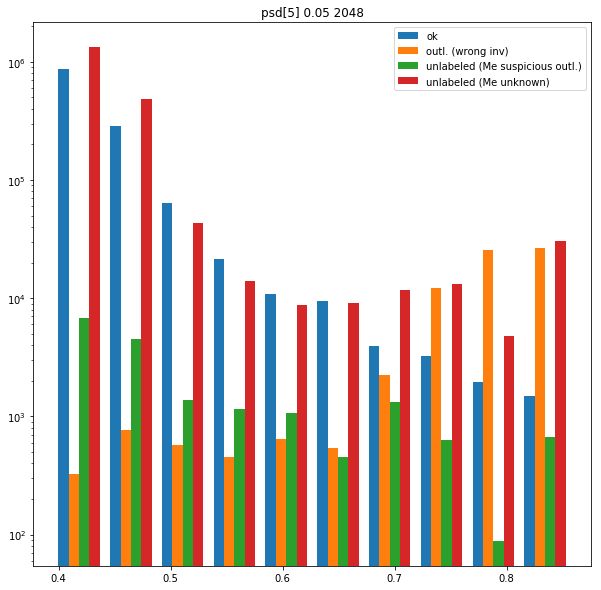

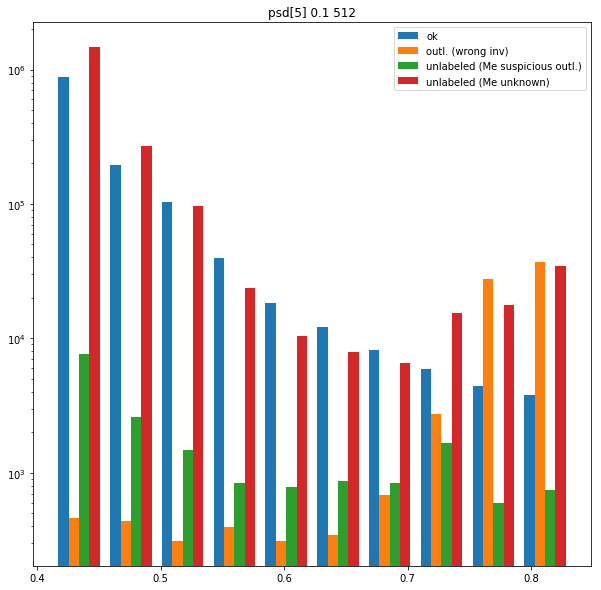

In [20]:
classnames = sod_core_dataset.allset_train.classnames
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in preds.items():
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.show()
#         prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#         print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#         prd_df_msclf.drop(['decision_function'], 1, inplace=True)
#         print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))

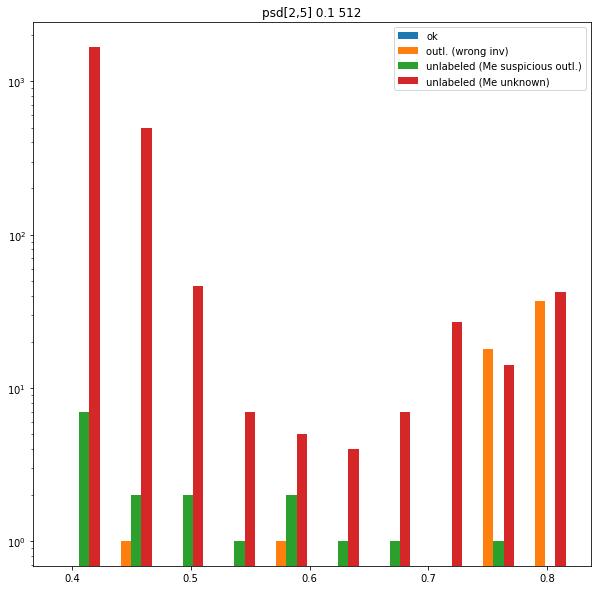

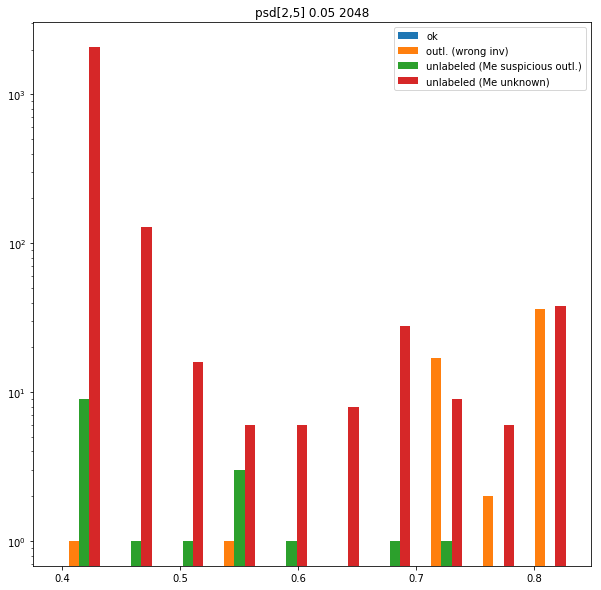

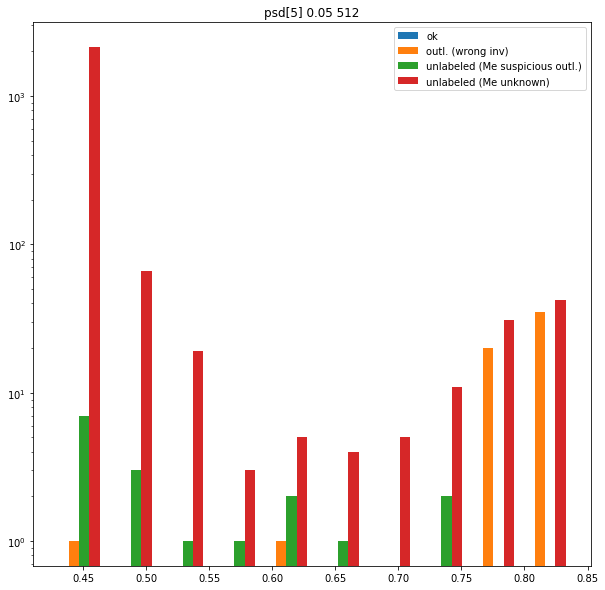

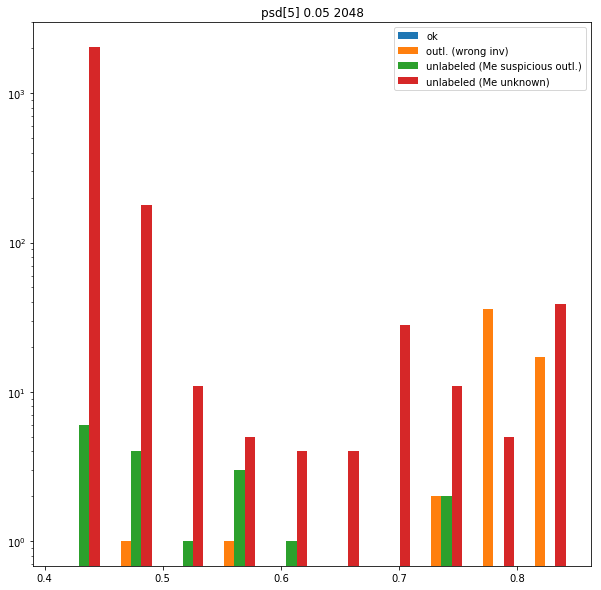

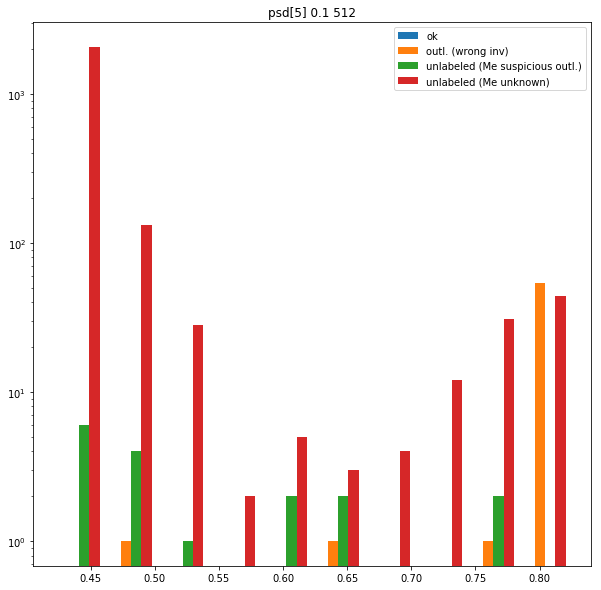

In [21]:
classnames = sod_core_dataset.allset_train.classnames
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in spreds.items():
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.show()


Performances

Estimating performances


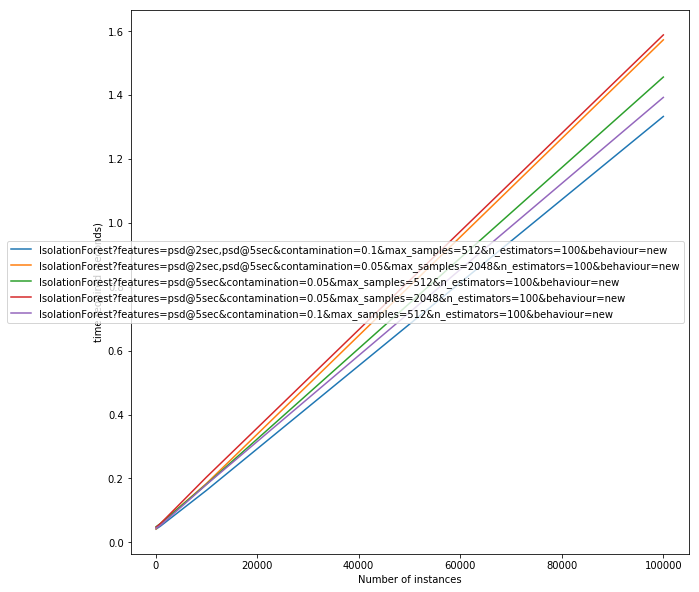

In [23]:
# adding now the two best overall:
import time
from sod.core.evaluation import _predict
# clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}


with plotparams({'figure.figsize': (10, 10)}):

    print('\nPerformances')

    numinst = (100, 1000, 10000, 100000)
    dfs = {_: dataframe.iloc[np.random.randint(0, len(dataframe), _)].dropna() for _ in numinst}
    print('\nEstimating performances')
    for name, clf in clfs.items():
        feats = fnames[name]
        feats = feats[feats.find('features=') + len('features='):].split('&')[0].split(',')
        # print(feats)
        plotdata = []
        for test in numinst:
            ints = np.random.randint(0, len(dataframe), test)
            # dataf = dataframe.iloc[ints]
            test_df = dfs[test][feats]
            t = time.time()
            #print(dataf[feats])
            # raise
            prd = _predict(clf, test_df)
            t = time.time() - t
            plotdata.append(t)
        plt.plot(numinst, plotdata, label=fnames[name])
    plt.xlabel('Number of instances')
    plt.ylabel('time required (seconds)')
    plt.legend()
plt.show()



In [ ]:
# fare un boxplot asse x: tempo, asse y: score_samples